# Fruit-360 Variational Autoencoder


In [1]:
!pip install keras-nightly

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import matplotlib.pyplot as plt
import gdown

In [3]:
id = '1h3gAHAAiFXQ0za7I4ShZSUEt74zmPDCc'
# Name the output file
output = 'data.zip'
# Call gdown to get the file
gdown.download(id=id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1h3gAHAAiFXQ0za7I4ShZSUEt74zmPDCc
From (redirected): https://drive.google.com/uc?id=1h3gAHAAiFXQ0za7I4ShZSUEt74zmPDCc&confirm=t&uuid=9020ad07-cffb-4cf5-9537-1cc331aa4198
To: /content/data.zip
100%|██████████| 425M/425M [00:17<00:00, 23.8MB/s]


'data.zip'

In [4]:
!unzip -q data.zip

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'fruits-360',
    validation_split=0,
    seed=123,
    image_size=(50, 50),
    batch_size=128,
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: x / 255.0)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 55238 files.


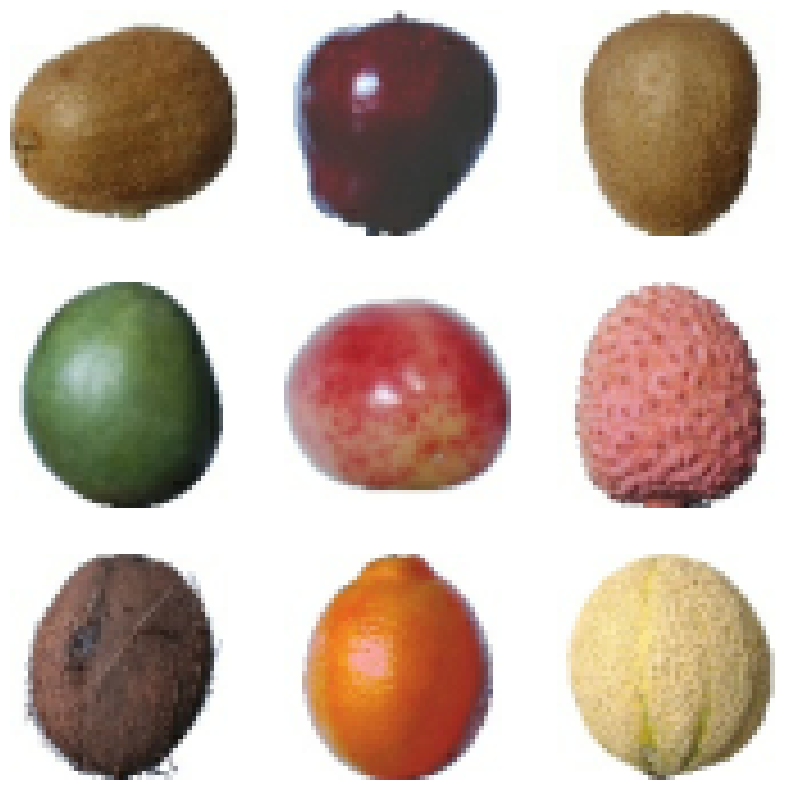

In [ ]:
for batch_images in train_dataset.take(1):
    # Plot the images in a 3 by 3 grid
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Adjust the range based on your batch size
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch_images[i].numpy())
        plt.axis('off')
    plt.show()


In [ ]:
@keras.utils.register_keras_serializable()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super(Sampling, self).get_config()
        return config

In [ ]:
def create_encoder(latent_dim=2):


    encoder_inputs = keras.Input(shape=(50, 50, 3))
    x = keras.layers.Conv2D(32, (5, 5), strides=(1, 1), activation='relu', padding='same')(encoder_inputs)
    x = keras.layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu')(x)
    x = keras.layers.Conv2D(32, (5, 5), strides=(1, 1), activation='relu')(x)
    x = keras.layers.Conv2D(32, (5, 5), strides=(1, 1), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

In [ ]:
def create_decoder(latent_dim=2):

    decoder_inputs = keras.Input(shape=(latent_dim,))

    x = keras.layers.Dense(128, activation='relu')(decoder_inputs)
    x = keras.layers.Dense(18 * 18 * 32, activation='relu')(x)
    x = keras.layers.Reshape((18, 18, 32))(x)

    x = keras.layers.Conv2DTranspose(32, (4, 4), activation='relu', strides=(1, 1))(x)
    x = keras.layers.Conv2DTranspose(32, (4, 4), activation='relu', strides=(1, 1))(x)
    x = keras.layers.Conv2DTranspose(32, (4, 4), activation='relu', strides=(2, 2))(x)
    decoder_outputs = keras.layers.Conv2D(3, (5, 5), activation='relu', strides=(1, 1), padding='same')(x)

    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return decoder

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reconstruction_weight = 1
        self.kl_weight = 1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss +  self.kl_weight * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
encoder = create_encoder()
decoder = create_decoder()
vae = VAE(encoder, decoder)
vae.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 50, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 50, 50, 32)     │          2,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 23, 23, 32)     │         25,632 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 19, 19, 32)     │         25,632 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 15, 15, 32)     │         25,632 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 7200)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        921,728 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            258 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            258 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,001,572 (3.82 MB)

 Trainable params: 1,001,572 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10368)               │       1,337,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 21, 21, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 24, 24, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 3)           │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,389,507 (5.30 MB)

 Trainable params: 1,389,507 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ?                           │       1,001,572 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ ?                           │       1,389,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,391,079 (9.12 MB)

 Trainable params: 2,391,079 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr * 0.1
    else:
        return lr

# Create the Adam optimizer with initial learning rate
optimizer = keras.optimizers.Adam(1e-3)

# Compile the VAE model with the Adam optimizer
vae.compile(optimizer=optimizer)

# Define a learning rate scheduler callback
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)


# Fit the VAE model with the learning rate scheduler
history = vae.fit(train_dataset, epochs=75, batch_size=128, callbacks=[lr_scheduler])

Epoch 1/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - kl_loss: 6588.1294 - loss: 29862.0430 - reconstruction_loss: 23273.9121 - learning_rate: 0.0010
Epoch 2/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - kl_loss: 7.3460 - loss: 297.2781 - reconstruction_loss: 289.9320 - learning_rate: 0.0010
Epoch 3/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - kl_loss: 7.1850 - loss: 238.3836 - reconstruction_loss: 231.1987 - learning_rate: 0.0010
Epoch 4/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - kl_loss: 7.1743 - loss: 219.9784 - reconstruction_loss: 212.8042 - learning_rate: 0.0010
Epoch 5/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - kl_loss: 7.1068 - loss: 208.5555 - reconstruction_loss: 201.4487 - learning_rate: 0.0010
Epoch 6/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - kl_loss: 7.1144 - loss: 199.9775 - reconstruction_loss: 192.8631 - learning_rate: 0.0010
Epoch 7/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - kl_loss: 7.1044 - loss: 193.3606 - reconstruction_loss: 186.2563 - 

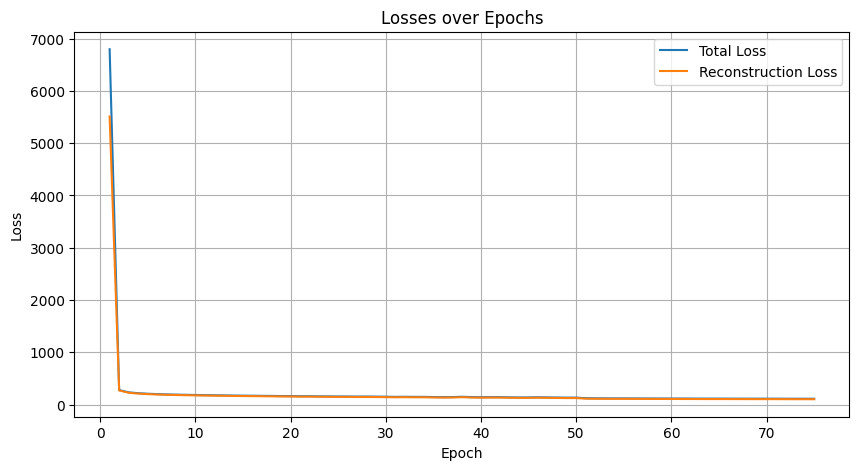

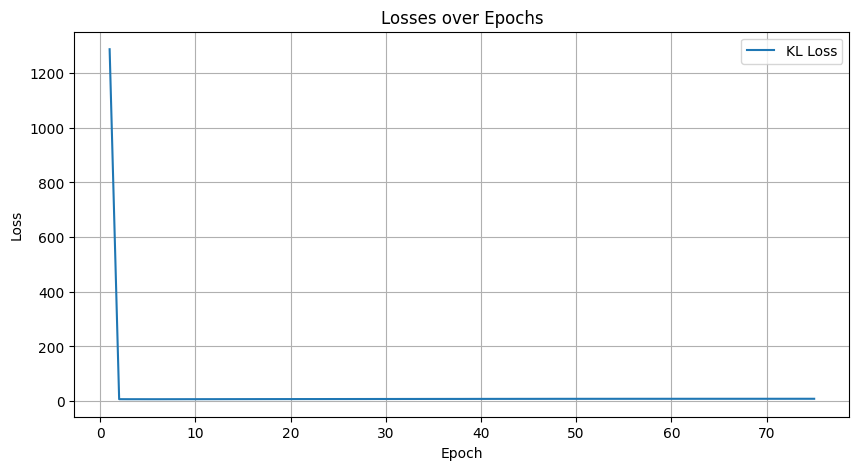

In [ ]:
import matplotlib.pyplot as plt

# Access loss values from the history object
kl_losses = history.history['kl_loss']
total_losses = history.history['loss']
reconstruction_losses = history.history['reconstruction_loss']
epochs = range(1, len(total_losses) + 1)

# Plot losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, kl_losses, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()


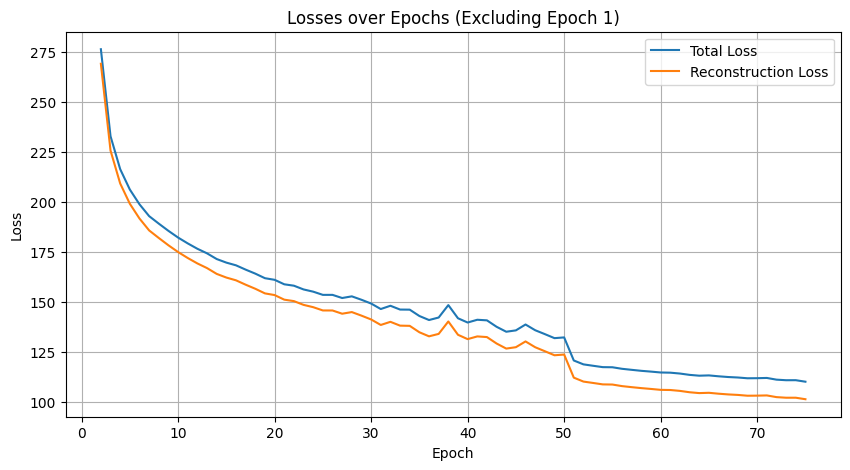

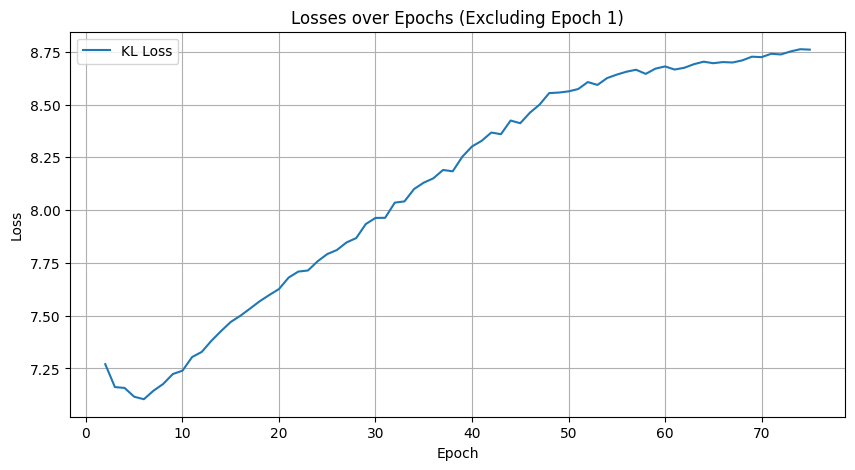

In [ ]:
import matplotlib.pyplot as plt

# Access loss values from the history object
kl_losses = history.history['kl_loss'][1:]
total_losses = history.history['loss'][1:]
reconstruction_losses = history.history['reconstruction_loss'][1:]
epochs = range(2, len(total_losses) + 2)

# Plot losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs (Excluding Epoch 1)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, kl_losses, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs (Excluding Epoch 1)')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


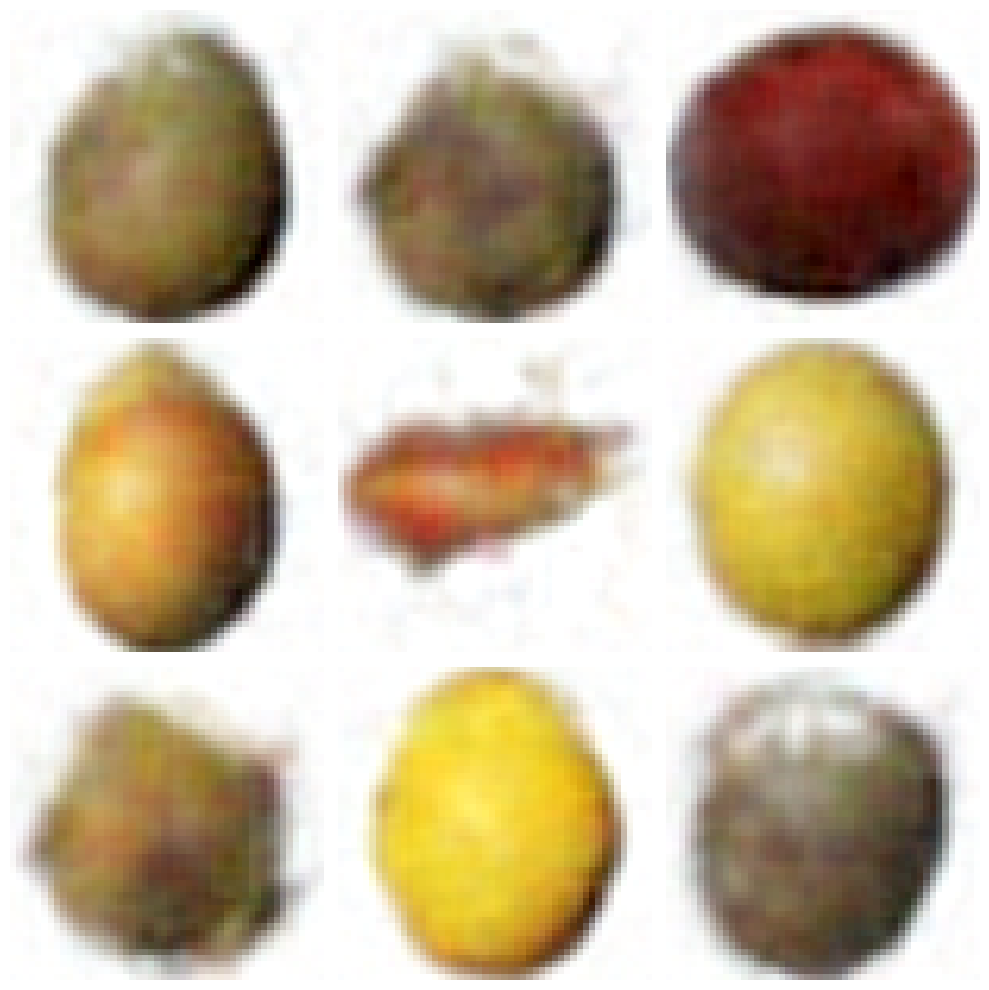

In [ ]:
def generate_random_images(vae, n=3):
    # Randomly sample points from the latent space
    latent_points = np.random.normal(size=(n*n, 2))

    # Decode the latent points to generate images
    decoded_images = vae.decoder.predict(latent_points)

    # Plot the generated images
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.imshow(decoded_images[i*n+j].reshape(50, 50, 3), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to generate and plot 9 random images
generate_random_images(vae, n=3)

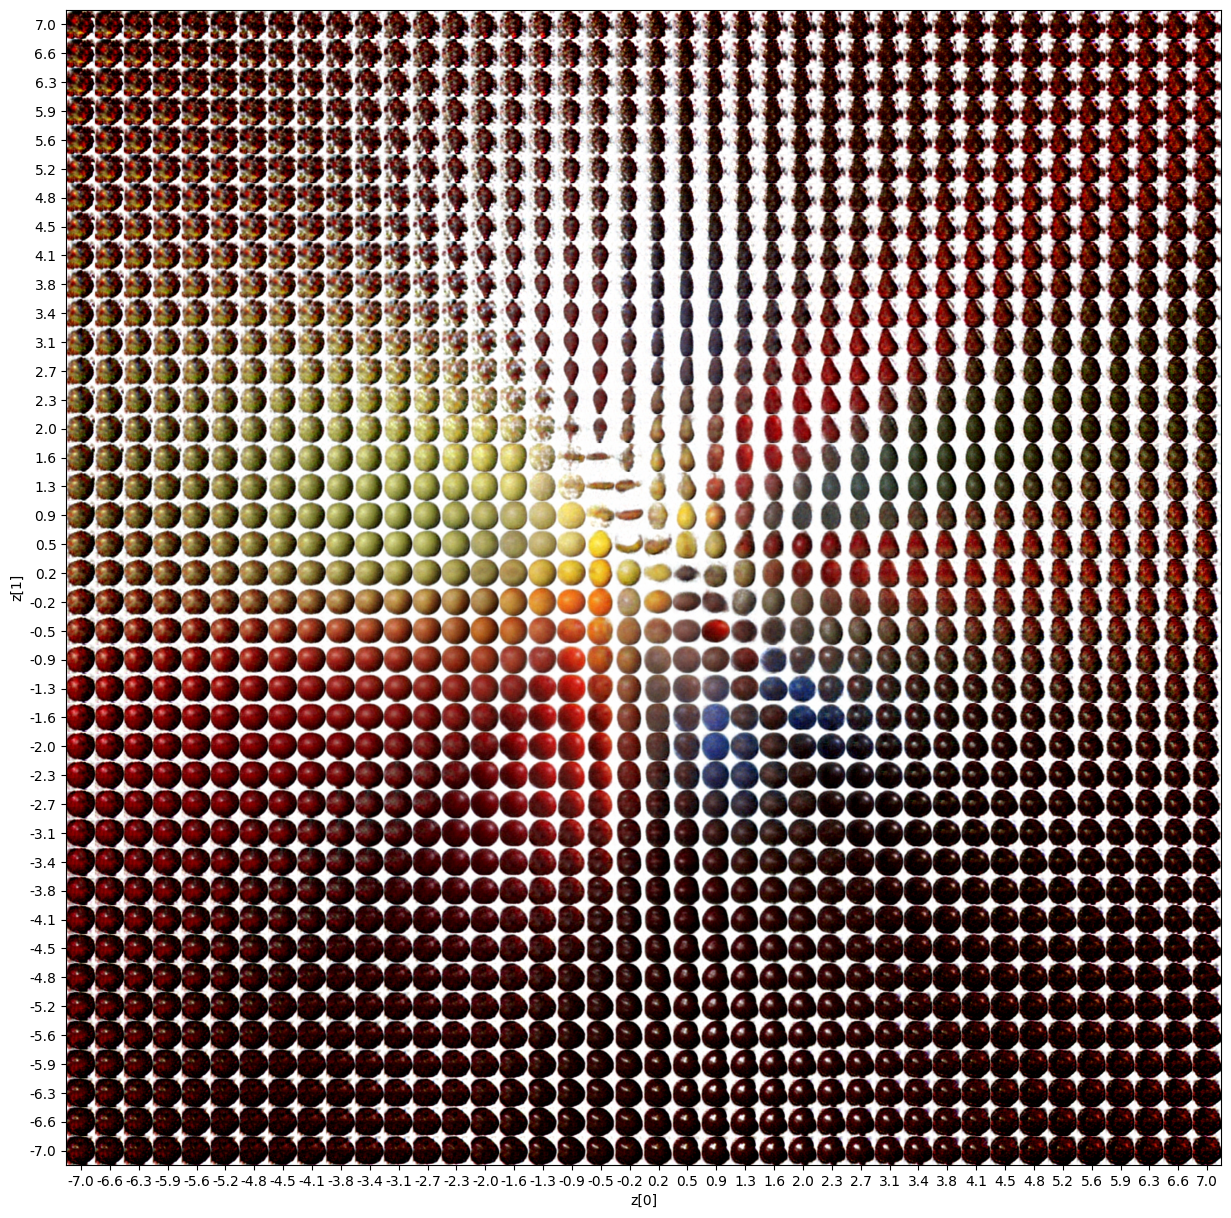

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of RGB images
    digit_size = 50  # Update with the appropriate size of your images
    scale = 7.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))  # Initialize with 3 channels for RGB

    # Linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)  # Reshape to include 3 channels
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                :
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

# Call the function to plot the latent space
plot_latent_space(vae, n=40)

In [ ]:
encoder.save_weights("encoder.weights.h5")
decoder.save_weights("decoder.weights.h5")

# Training with more latent space for sharper images

In [ ]:
crisper_encoder = create_encoder(8)
crisper_decoder = create_decoder(8)
crisper_vae = VAE(crisper_encoder, crisper_decoder)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 50, 50, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 50, 50, 32)     │          2,432 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 23, 23, 32)     │         25,632 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 19, 19, 32)     │         25,632 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 15, 15, 32)     │         25,632 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 7200)           │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │        921,728 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 8)              │          1,032 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 8)              │          1,032 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 8)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,003,120 (3.83 MB)

 Trainable params: 1,003,120 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10368)               │       1,337,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 21, 21, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 24, 24, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 50, 50, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 3)           │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,390,275 (5.30 MB)

 Trainable params: 1,390,275 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr * 0.1
    else:
        return lr

# Create the Adam optimizer with initial learning rate
optimizer = keras.optimizers.Adam(1e-3)

# Compile the VAE model with the Adam optimizer
crisper_vae.compile(optimizer=optimizer)

# Define a learning rate scheduler callback
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)


# Fit the VAE model with the learning rate scheduler
history = crisper_vae.fit(train_dataset, epochs=75, batch_size=128, callbacks=[lr_scheduler])

Epoch 1/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - kl_loss: 31.2348 - loss: 1144.9453 - reconstruction_loss: 1113.7102 - learning_rate: 0.0010
Epoch 2/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - kl_loss: 16.6349 - loss: 158.9126 - reconstruction_loss: 142.2776 - learning_rate: 0.0010
Epoch 3/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - kl_loss: 17.9423 - loss: 112.0048 - reconstruction_loss: 94.0625 - learning_rate: 0.0010
Epoch 4/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - kl_loss: 18.4675 - loss: 93.9649 - reconstruction_loss: 75.4975 - learning_rate: 0.0010
Epoch 5/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - kl_loss: 18.6683 - loss: 85.9514 - reconstruction_loss: 67.2832 - learning_rate: 0.0010
Epoch 6/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - kl_loss: 18.7801 - loss: 80.0686 - reconstruction_loss: 61.2886 - learning_rate: 0.0010
Epoch 7/75
432/432 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - kl_loss: 18.9159 - loss: 76.4526 - reconstruction_loss: 57.5367 - learnin

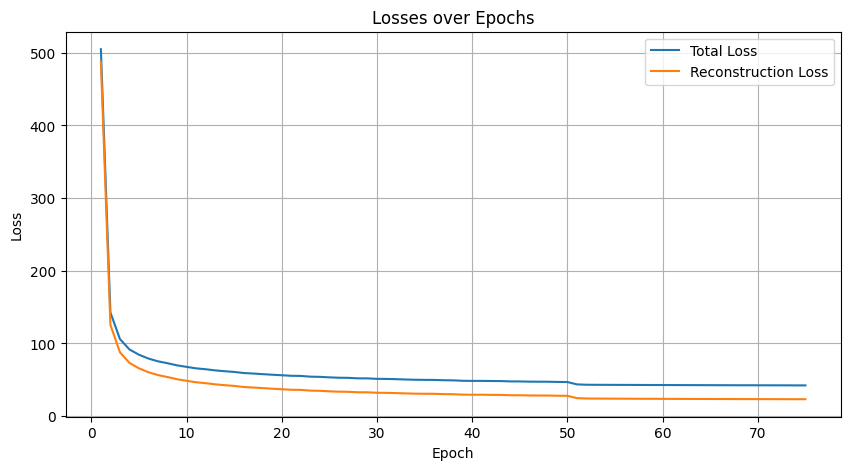

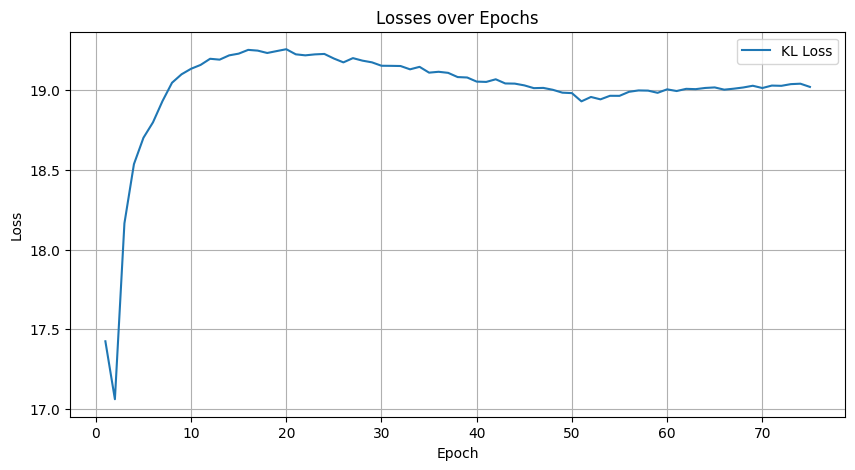

In [ ]:
import matplotlib.pyplot as plt

# Access loss values from the history object
kl_losses = history.history['kl_loss']
total_losses = history.history['loss']
reconstruction_losses = history.history['reconstruction_loss']
epochs = range(1, len(total_losses) + 1)

# Plot losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, kl_losses, label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


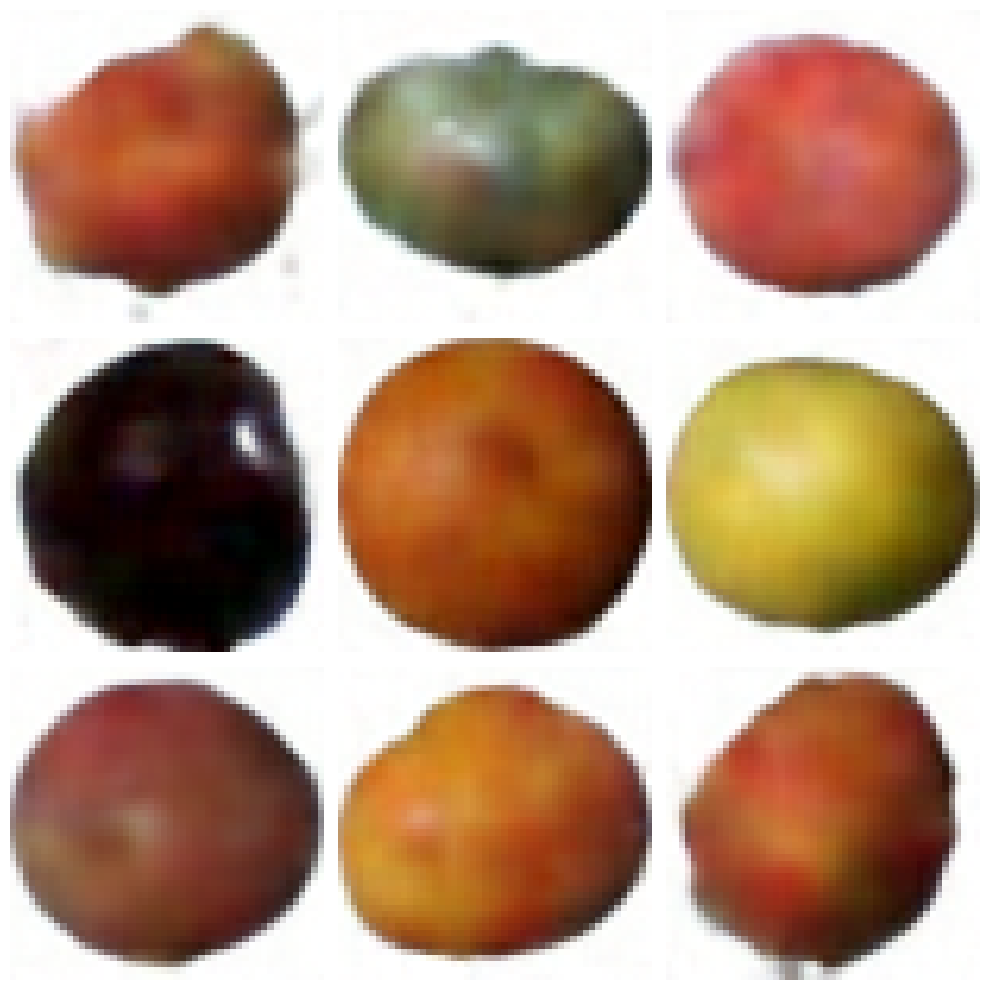

In [ ]:
def generate_random_images_crisper(vae, n=3):
    # Randomly sample points from the latent space
    latent_points = np.random.normal(size=(n*n, 8))

    # Decode the latent points to generate images
    decoded_images = vae.decoder.predict(latent_points)

    # Plot the generated images
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.imshow(decoded_images[i*n+j].reshape(50, 50, 3), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to generate and plot 9 random images
generate_random_images_crisper(crisper_vae, n=3)

In [ ]:
crisper_encoder.save_weights("crisper_encoder.weights.h5")
crisper_decoder.save_weights("crisper_decoder.weights.h5")

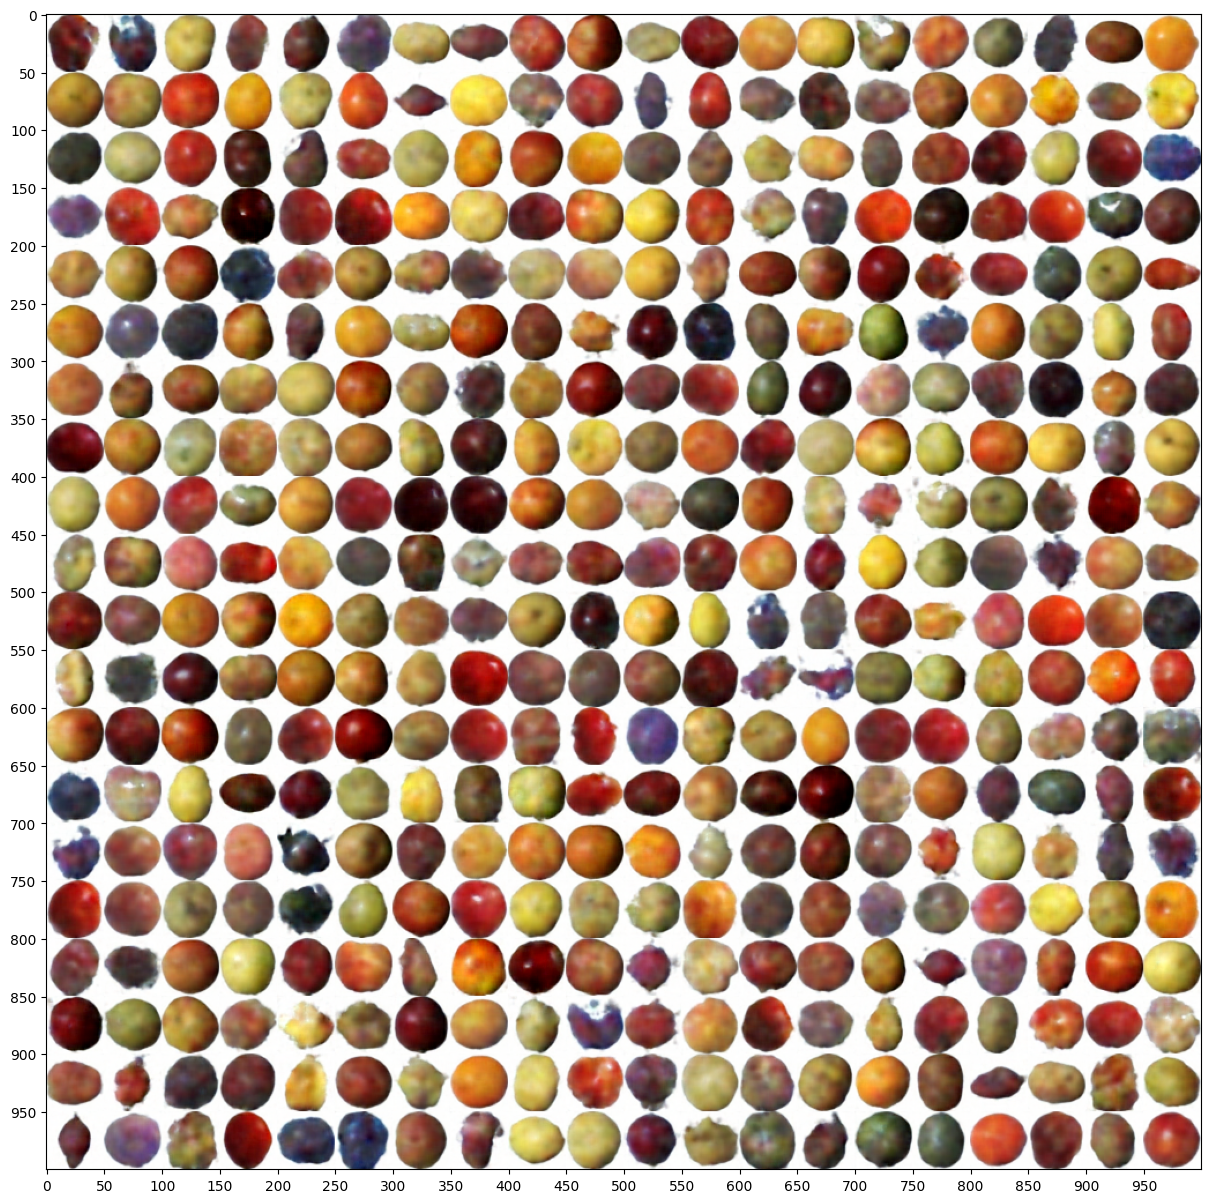

In [ ]:
def plot_random_images(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of RGB images
    digit_size = 50  # Update with the appropriate size of your images
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))  # Initialize with 3 channels for RGB

    # Randomly sampled coordinates corresponding to the 2D plot
    random_coords = np.random.normal(0, scale, size=(n, n, 8))

    for i in range(n):
        for j in range(n):
            z_sample = random_coords[i, j, :]
            x_decoded = vae.decoder.predict(np.array([z_sample]), verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)  # Reshape to include 3 channels
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                :
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    pixel_range = np.arange(0, n * digit_size, digit_size)
    plt.xticks(pixel_range)
    plt.yticks(pixel_range)
    plt.imshow(figure)
    plt.show()

# Call the function to plot the latent space
plot_random_images(crisper_vae, n=20)